In [1]:
import zipfile
import collections
import zarr
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

## Top level stats

The dataset consists of 3,960,704 sequences of length 29903 base pairs along with 31 metadata columns encoding information about those samples. This full dataset is stored in a single 345MiB zip file, 241MiB of which is used by the alignment data. This gives an average compression ratio of 468X.

In [3]:
data_path = "./viridian_2024-04-29.alpha1.zarr.zip"
store = zarr.ZipStore(data_path)
root = zarr.open(store, mode="r")
root.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, icon='table', name='call_genotype (29903,…

In [5]:
! ls -lh ./viridian_2024-04-29.alpha1.zarr.zip

-rw-r--r-- 1 jk jk 345M Jan 22 15:37 ./viridian_2024-04-29.alpha1.zarr.zip


In [6]:
num_metadata_cols = len([k for k in root.keys() if k.startswith("sample_")]) - 1
num_metadata_cols

31

In [7]:
root["call_genotype"].shape

(29903, 3960704, 1)

In [8]:
root["call_genotype"].chunks

(100, 10000, 1)

# Plot chunk size over time

In [14]:
z = zipfile.ZipFile(data_path)

In [15]:
sample_chunk_sizes = collections.Counter()
for zi in z.infolist():
    if zi.filename.startswith("call_genotype"):
        indexes = list(zi.filename.split("/"))
        if len(indexes) == 4 and len(indexes[-1]) > 0:
            sample_chunk = int(indexes[2])
            sample_chunk_sizes[sample_chunk] += zi.file_size


In [16]:
# Compute uncompressed size of a full sample chunk
call_genotype_array = root["call_genotype"]
uncompressed_chunk_size = call_genotype_array.blocks[:, 0].nbytes
uncompressed_chunk_size

299030000

In [17]:
total_genotypes_bytes = sum(sample_chunk_sizes.values())
total_genotypes_bytes

252887096

### Overall size

Get the overall size of the genotypes from the zip and compression ratio:

In [18]:
import humanize
humanize.naturalsize(total_genotypes_bytes, binary=True)

'241.2 MiB'

In [19]:
call_genotype_array.nbytes / total_genotypes_bytes 

468.3391663131756

In [14]:
# Compute the midpoint date from each sample chunk
a = root["sample_Collection_date"]
chunk_dates = {}
for k in range(4, a.cdata_shape[0]):
    c = a.blocks[k].astype(str)
    dates = c[np.char.str_len(c) == 10]
    dates = dates.astype("datetime64[D]")
    chunk_dates[k] = dates[len(dates) // 2]

In [75]:
data = []
for j, date in chunk_dates.items():
    data.append({
        "date": date,
        "diversity": chunk_diversity[j],
        "size": sample_chunk_sizes[j]})

df_chunk_size = pd.DataFrame(data)
df_chunk_size["compression_ratio"] = uncompressed_chunk_size / df_chunk_size["size"] 
df_chunk_size

,date,diversity,size,compression_ratio
0,2020-03-11,0.001733,802770,372.497727
1,2020-03-24,0.000381,713293,419.224638
2,2020-04-02,0.000392,686073,435.857409
3,2020-04-15,0.000419,691695,432.314821
4,2020-05-02,0.000459,702424,425.711536
...,...,...,...,...
388,2022-12-19,0.001334,734649,407.037919
389,2022-12-30,0.001524,753628,396.787274
390,2023-01-15,0.001602,779796,383.472088
391,2023-02-06,0.001565,629517,475.014972


## Compute diversity in chunks


In [46]:
import allel

In [72]:
gt_array = root["call_genotype"]
# Make a Zarr array with the same chunk size to make indexing by block easy
chunk_diversity = np.zeros(shape=gt_array.cdata_shape[1])

for s_chunk in tqdm(range(gt_array.cdata_shape[1])): 
    h = allel.HaplotypeArray(gt_array.blocks[:, s_chunk].squeeze())
    ac = h.count_alleles()
    pi = allel.mean_pairwise_difference(ac)
    chunk_diversity[s_chunk] = np.mean(pi[~np.isnan(pi)])

  0%|          | 0/397 [00:00<?, ?it/s]

## Compute the Scorpio prevalance over time from metadata

In [23]:
df_scorpio = pd.DataFrame({
    "date": root["sample_Collection_date"],
    "scorpio": root["sample_Viridian_scorpio"],
    "count": np.ones(root["sample_id"].shape[0])})
df_scorpio

,date,scorpio,count
0,.,.,1.0
1,.,.,1.0
2,.,Delta (B.1.617.2-like),1.0
3,.,Delta (B.1.617.2-like),1.0
4,.,Delta (B.1.617.2-like),1.0
...,...,...,...
3960699,not applicable,.,1.0
3960700,not applicable,.,1.0
3960701,not applicable,.,1.0
3960702,not applicable,Omicron (BA.2-like),1.0


In [24]:
# Subset down to things that have a precise date and convert to datetime
df_scorpio = df_scorpio[df_scorpio.date.str.len() == 10].copy()
df_scorpio["date"] = np.array(df_scorpio["date"], dtype="datetime64[D]")

In [26]:
# Pivot so we get counts of Scorpio values per day
df_pivot = df_scorpio.pivot_table(
    columns="scorpio", index="date", values="count", aggfunc="sum", fill_value=0)
df_pivot

scorpio,.,A.23.1-like,A.23.1-like+E484K,AV.1-like,Alpha (B.1.1.7-like),B.1.1.318-like,B.1.1.7-like+E484K,B.1.617.1-like,B.1.617.3-like,Beta (B.1.351-like),...,Probable Omicron (BA.1-like),Probable Omicron (BA.2-like),Probable Omicron (BA.3-like),Probable Omicron (BA.5-like),Probable Omicron (Unassigned),Probable Omicron (XBB-like),Probable Omicron (XBB.1-like),Probable Omicron (XBB.1.5-like),Theta (P.3-like),Zeta (P.2-like)
date,,,,,,,,,,,,,,,,,,,,,
1900-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1922-05-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1931-08-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-07-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
def scorpio_to_major_voc(scorpio):
    keys = {"Alpha", "Delta", "BA.1", "BA.2", "BA.4", "BA.5", "BQ.1", "XBB"}
    for k in keys:
        if k in scorpio:
            return k
    if "Omicron" in scorpio:
        return "Other_Omicron"
    return "Other"

def merge_scorpio_columns(df):
    out_cols = {}
    for col, values in df.items():
        voc = scorpio_to_major_voc(col)
        if voc not in out_cols:
            out_cols[voc] = values.copy()
        else:
            out_cols[voc] += values
    return pd.DataFrame(out_cols)

df_major_voc = merge_scorpio_columns(df_pivot)
df_major_voc

,Other,Alpha,Delta,BA.1,BA.2,Other_Omicron,BA.4,BA.5,XBB
date,,,,,,,,,
1900-01-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1922-05-19,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1931-08-27,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2001-07-30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
2023-02-17,0.0,0.0,0.0,0.0,97.0,1.0,0.0,75.0,145.0
2023-02-18,0.0,0.0,0.0,0.0,49.0,0.0,0.0,13.0,24.0
2023-02-19,0.0,0.0,0.0,0.0,14.0,0.0,0.0,7.0,6.0


In [28]:
def compute_fractions(df):
    sum_col = sum(col for _, col in df.items())
    #print(df.copy)
    copy = df.copy()
    #print(copy)
    for k, v in df.items():
        copy[k] = v / sum_col
    return copy

df_major_voc = compute_fractions(df_major_voc)

## Make the plot

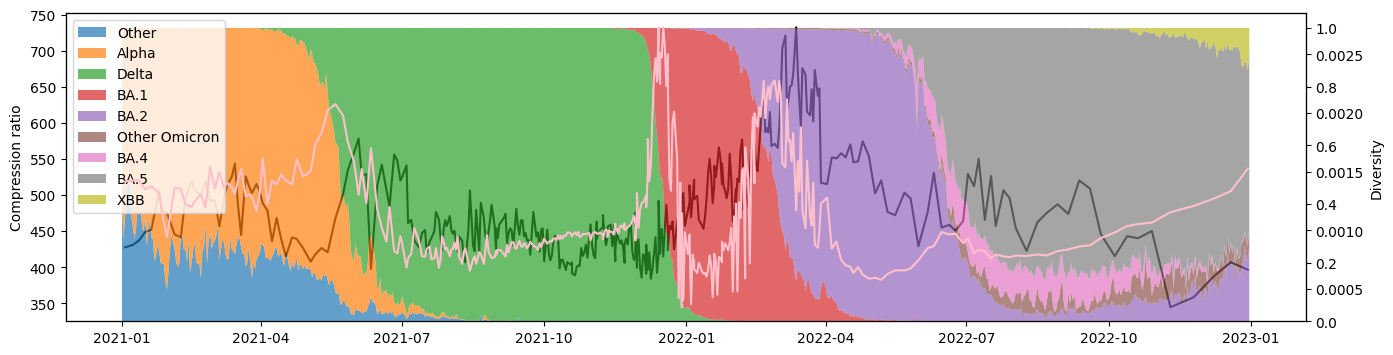

In [82]:
start = np.array(["2021-01"], dtype="datetime64")[0]
end = np.array(["2023-01"], dtype="datetime64")[0]

df_voc = df_major_voc[(start <= df_major_voc.index) & (df_major_voc.index < end)]
df_cs = df_chunk_size[(start <= df_chunk_size.date) & (df_chunk_size.date < end)]

fig, ax = plt.subplots(1, figsize=(16, 4))

ax3 = ax.twinx()
ax3.stackplot(df_voc.index, 
    *[df_voc[voc] for voc in df_voc], 
    labels=[" ".join(k.split("_")) for k in df_voc], 
    alpha=0.7)
ax2 = ax.twinx()
ax2.set_ylabel("Diversity")
ax2.plot(df_cs["date"], df_cs["diversity"], color="pink")
ax.plot(df_cs["date"], df_cs["compression_ratio"], color="black")
ax.set_ylabel("Compression ratio")
ax3.legend(loc="upper left");

## NOTES

Note: this isn't quite what i'd been expecting. One would assume that peak compression would correspond with the lowest diversity, but this is not what we're seeing. Needs some more looking at.

# Performing calculations

## Compute non-ACGT values per sample

We want to know how many bases per sample are Ns, gaps or ambiguous. The IUPAC alleles are encoded as ACGT = (0, 1, 2, 3) so we can find anything that's not these by excluding missing values (-1) or anything >= 4.

This takes 3 minutes to compute in a single thread. Accessing the haplotype for a single sample in the middle of the matrix required 163 ms and accessing the genotypes for a given site required 163ms.

In [42]:
%%time
gt_array = root["call_genotype"]
# Make a Zarr array with the same chunk size to make indexing by block easy
missing_count = zarr.zeros(shape=gt_array.shape[1], chunks=gt_array.chunks[1], dtype=int)

for s_chunk in tqdm(range(gt_array.cdata_shape[1])): 
    H = gt_array.blocks[:, s_chunk].squeeze(axis=2).T
    missing_count.blocks[s_chunk] = np.sum((H < 0) | (H >= 4), axis=1)

  0%|          | 0/397 [00:00<?, ?it/s]

CPU times: user 2min 34s, sys: 23.6 s, total: 2min 57s
Wall time: 2min 57s


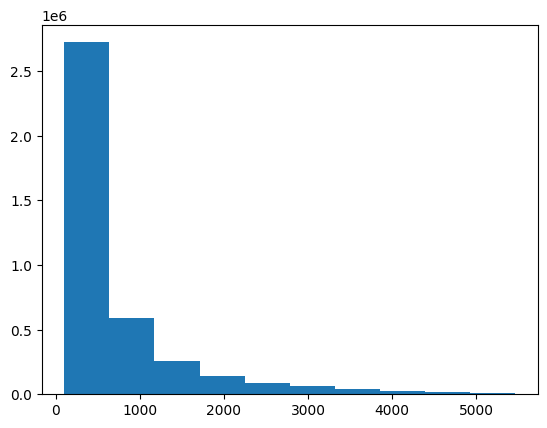

In [43]:
plt.hist(missing_count[:]);

## Get a single sample's haplotype

In [44]:
%%time
k = gt_array.shape[1] // 2
h = gt_array[:, k].squeeze(axis=1).T

CPU times: user 172 ms, sys: 16.5 ms, total: 188 ms
Wall time: 163 ms


## Get genotypes for a single site


In [45]:
%%time
j = gt_array.shape[0] // 2
g = gt_array[j].squeeze(axis=1).T

CPU times: user 203 ms, sys: 7.21 ms, total: 210 ms
Wall time: 209 ms
